# <h1 align="center">Basic Models: A Sentiment Analysis Case Study on movie reviews</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. Inside this dataset there are 25,000 labeled movies reviews for training, 50,000 unlabeled reviews for training, and 25,000 reviews for testing.

- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
<img src="https://i.imgur.com/lQNnqgi.png" align="right">
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)

## <h2 align = "center" >Dependecies</h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# for importing data to colab
from google.colab import drive 
drive.mount('/content/drive')

# read from local
# movies = pd.read_csv('data/imdb_data.csv')
# movies.sample(7)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## <h2> <center>Preliminary Data Exploration</center></h2>

In [3]:
movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/imdb_data.csv')
movies.sample(7)

,review,sentiment
13065,"This movie is watchable, but nothing special. ...",negative
43650,This wartime sitcom written by Jimmy Perry and...,positive
23691,A Brief History of Time is not only a document...,positive
36643,I was deeply moved by this movie in many respe...,positive
33188,"I was pulled into this movie early on, much to...",negative
37517,First off... I have to say acting isn't very g...,negative
32809,Witty. Quirky. Genuine. Surreal. Butterfly win...,negative


In [4]:
movies.dtypes

review       object
sentiment    object
dtype: object

In [5]:
movies.isna().sum()

review       0
sentiment    0
dtype: int64

In [6]:
#sentiment count
movies['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

> No missing values in the dataset

In [7]:
# Looking at sample review
sample = 777
sample_review = movies.review.iloc[sample]
print(sample_review)
print("\nAssigned sentiment: ", movies.sentiment.iloc[sample])

It's amazing that such a cliche-ridden yuppie angst film actually got made in the first place. The characters are so weak, and the acting so uninspired, that it's impossible to care about any of them-- especially Brooke Shields. The temptation to fast forward through the slow parts is almost irresistible. If you like this genre, you'd be better off renting "Singles," or "Bodies, Rest & Motion."

Assigned sentiment:  negative


> **Contains html tags, accented characters, punctutations and emoticons, numbers... etc., Should deal with them in the preprocessing step**

In [8]:
# Cateogrize positive and negative as 1 and 0 respectively
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

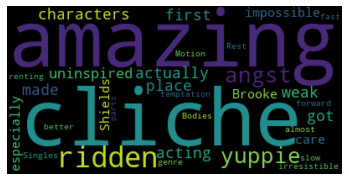

In [10]:
from wordcloud import WordCloud, STOPWORDS

my_stop_wrods = set(STOPWORDS)
my_stop_words = STOPWORDS.update(['movie', 'cinema', 'theatre', 'movies', 'TV', 'film', 'films', 'br', 'one'])

my_cloud = WordCloud(stopwords=my_stop_words).generate(sample_review)
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

## <h2> <center>Preprocessing</center></h2>

In [11]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import os
import multiprocessing

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
!pip install langdetect

     |████████████████████████████████| 983kB 9.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=d40781fe4dcc9bd6dc1cfd4b012ebe637db0a8e960e96eed426967f2b626f97a
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [13]:
"""
# Looking for languages
from langdetect import detect_langs

languages =[]
# pick 500 random reviews out of the dataset as langauge detection on every review is not feasible
samples = np.random.choice(len(movies.review), size = 2000, replace = False)
# Loop over the rows of the dataset and append  
for row in samples:
    languages.append(detect_langs(movies.review[row]))

# Clean the list by splitting     
languages = [str(lang).split(':')[0][1:] for lang in languages]

print("Unique languages in the reviews: ", np.unique(languages))
"""

'\n# Looking for languages\nfrom langdetect import detect_langs\n\nlanguages =[]\n# pick 500 random reviews out of the dataset as langauge detection on every review is not feasible\nsamples = np.random.choice(len(movies.review), size = 2000, replace = False)\n# Loop over the rows of the dataset and append  \nfor row in samples:\n    languages.append(detect_langs(movies.review[row]))\n\n# Clean the list by splitting     \nlanguages = [str(lang).split(\':\')[0][1:] for lang in languages]\n\nprint("Unique languages in the reviews: ", np.unique(languages))\n'

> **We can be fairly certain all the reviews are in english. No need to consider other languages while preprocessing**

In [0]:
# Finding out the most frequent words in our specific dataset to add stopwords customized to the movie reviews domain
from collections import Counter

top_N = 50

stopwords = nltk.corpus.stopwords.words('english')
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (movies.review
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DataFrame out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [15]:
rslt.transpose()

Word,',/><br,.,movie,",",/>,film,one,like,(,would,even,good,really,see,-,get,much,story,also,time,great,first,make,people,could,"""",made,bad,think,many,<br,never,two,little,well,watch,way,movie.,know,love,best,seen,characters,.<br,character,movies,ever,still,films
Frequency,154326,100980,62875,61492,61228,56642,55086,44983,37281,25317,23807,23681,23467,21805,20901,19159,17689,17278,16810,15743,15658,15465,15455,15028,15028,14927,14384,13562,13494,13304,12877,12764,12621,12189,11827,11692,11461,11375,10902,10784,10748,10743,10611,10599,10474,10386,10349,10218,9778,9578


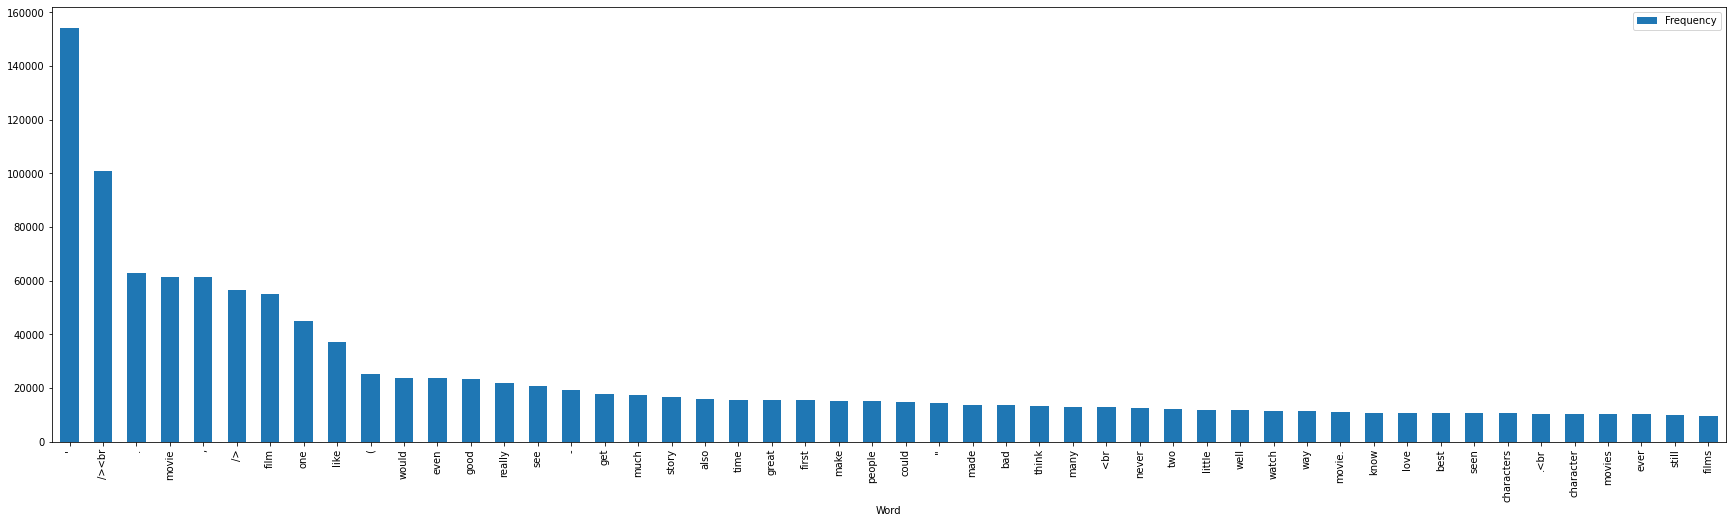

In [16]:
# plot
rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

### <h2> <center>Helper functions to aid in preprocessing the text </center></h2>

In [17]:
def sample_reviews(samples = 7):
    for review in movies['review'].sample(samples):
        print(review)
        print("")

sample_reviews()

Yet another colourful excuse for men in rubber suits to wrestle with each other. This time around, time travellers from the future arrive in 1992 and recruit a few people to go back with them to 1944 and prevent the creation of Godzilla, thus saving a future Japan from destruction. But having accomplished this task, the time travellers are revealed to be a bunch of double crossers whose own creature goes on the rampage, and with no Godzilla to stop it Eek! It all sounds very silly, and it probably is, but the plot is surprisingly decent and the final battle looks pretty good too. Unfortunately the rest of the visual effects are just rubbish rather than enjoyably rubbish, and the movie turns out to be just as dull as its predecessors. Look out for the shaky Spielberg in-joke.

Choose your fate: The terrible tykes of the fourth form, playing practical jokes that involve axes, or the...ummm...well-developed girls of the sixth form, who discovered some time ago cigarettes, gin, sex and ho

In [18]:
def strip_html_tags(review_text):
    soup = BeautifulSoup(review_text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text
movies['review'] = movies['review'].apply(strip_html_tags)
sample_reviews()

Is there any other time period that has been so exhaustively covered by television (or the media in general) as the 1960s? No. And do we really need yet another trip through that turbulent time? Not really. But if we must have one, does it have to be as shallow as "The '60s"? I like to think that co-writers Bill Couturie and Robert Greenfield had more in mind for this two-part miniseries than what ultimately resulted, especially given Couturie's involvement in the superb HBO movie "Dear America: Letters Home From Vietnam" which utilized little original music and no original footage, letting the sights and sounds of the time speak for themselves. This presentation intercuts file footage with the dramatic production, but it doesn't do anyone any favours by trying to do too much in too little time; like so many of its ilk, it's seen from the point of view of one family. But the children of the family seem to be involved tangentially with almost every major event of the '60s (it's amazing 

In [19]:
import unicodedata

def replace_accented_chars(review_text):
    unaccented_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return unaccented_text
movies['review'] = movies['review'].apply(replace_accented_chars)
sample_reviews()

This is a very well-made film, meticulously directed and with some excellent character acting that at times is deeply moving - for example the scene with the loyal but unsophisticated sidekick cop and his wife. The plot is convincingly worked out and exciting. The gangster character is particularly interesting and plays an almost metaphysical role in the life of the hero. It's made clear that the cops are just as rough and ready as the underworld characters.A couple of slight reservations: I found the ending slightly one-sided as it celebrates the hero's successful integration into the structure of the police and justice system, which collapses the ambiguity of the police characters which has been maintained up to that point. Also I found the lead female character somewhat weak: little more than a catalyst for the salvation of the hero, all she seems to do is weep and swoon as the tough guys battle it out.

1st watched 12/26/2008 -(Dir-Eugene Levy): Corny comedy murder mystery with ver

In [20]:
def remove_special_characters(review_text):
    """ 
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review """
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_special_characters)
sample_reviews()

What Game Over  Kasparov and the Machine does best is to delve into Garry Kasparov's psyche during the 1997 competition against IBM's Deep Blue  You see him becoming more and more paranoid  and increasingly unravelled  all because in the second game  Deep Blue made a move that seemed too human for his preconceived notion of chess computers  Kasparov thought then  and still does  that IBM cheated Game Over tries to seem unbiased  but it is clear that the director thinks that IBM cheated  However  they give no real evidence to support the cheating claim  only intimations that IBM's security surrounding the computer room was because IBM really had grandmasters hidden in there overriding the computer on certain key occasions  and Kasparov's assertion that the computer didn't play like a computer usually does at one point in game two  In game two  Kasparov played a game that was designed to trick the computer  attempting to sacrifice a pawn in a situation where previous computer chess progr

In [21]:
!pip install contractions
!pip install textsearch

     |████████████████████████████████| 317kB 9.3MB/s 
     |████████████████████████████████| 245kB 14.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81698 sha256=470d5e8463787e8d0afaa4269165d288985afb5a77580a53088c99f7d36b49b3
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [22]:
import contractions
def expand_contractions(review_text):
    review_text = contractions.fix(review_text)
    return review_text
movies['review'] = movies['review'].apply(expand_contractions)
sample_reviews()

`The Matrix' was an exciting summer blockbuster that was visually fantastic but also curiously thought provoking in its `Twilight Zone' ish manner  The general rule applies here  and this sequel does not match up to its predecessor  Worse than that  it does not even compare with it `Reloaded' explodes onto the screen in the most un professional fashion  In the opening few seconds the first impression is a generally good one as Trinity is shot in a dream  Immediately after that  the film nose dives  After a disastrous first 45 minutes  it gradually gains momentum when they enter the Matrix and the Agent Smith battle takes place  But it loses itself all speed when it reaches the 14 minute car chase sequence and gets even worse at the big groan worthy twist at the end  Worst of all is the overlong `Zion Rave' scene  Not only does it have absolutely nothing to do with the plot  but it is also a pathetic excuse for porn and depressive dance music The bullet time aspect of `The Matrix' was a

In [23]:
# takes time ...
def strip_stops(review_text, is_lower_case=False, custom = True):
    tokens = word_tokenize(review_text)
    tokens = [token.strip() for token in tokens]
    if custom:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        # custom stopwords added from the most frequent words which are generic and might not relate to the sentiment of the review
        stop_words.update(['movie', 'film', 'one', 'would', 'even', 'really', 'movies', 'films', 'cinema', 'character' , 'show' , "'"])
    else:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

movies['review'] = movies['review'].apply(strip_stops)
sample_reviews()

Larry Donner Billy Crystal crazy life wife Kate Mulgrew stole book left new budding romance girl named Beth Kim Greist know start book students screen writing class stranger However student Danny DeVito extra strange lives evil Momma Anne Ramsey get courage kill goes Larry help making life go normal crazy extra crazy ! Stu Silver done ! dialog characters whole script near perfect ! Danny DeVito proved great actor great director ! kid 's Matilda among favorite family favorite comedies black comedy jokes murder damn funny ! actors full potential whether main characters Billy Crystal bit minor characters Olivia Brown like comedy ? like ! 8 10 stars

Pickup South Street brilliant ever made example directing Candy Jean Peters starts going purse notices wallet missing alarm goes background building alarm going head cartoon like subtly woven background way strikes subconscious level seen times clicks alarm bell going starts frantically going bag Richard Widmark way top game smart alec great h

In [24]:
# takes time ...
def snowball_stem(review_text):
    words = review_text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    review_text = " ".join(stemmed_words)
    return review_text

movies['review']=movies['review'].apply(snowball_stem)
sample_reviews()

third muppet last jim henson around take part make prematur death 1990 first three star famous charact made releas theatr born origin saw first second instal origin trilog muppet great muppet caper around mid nineti kid see third muppet take manhattan april 2007 short seen two predecessor 1996 's muppet treasur island first time mani year third muppet definit disappoint first time saw second view near three year later may impress much certain go far downhil muppet stage music manhattan melodi turn big hit colleg campus graduat colleg soon leav decid stay togeth go manhattan tri get broadway arriv begin search produc mani reject final decid part go find job leav town kermit stay still determin find right produc reunit muppet gang get job new york restaur own man name pete frog quick befriend pete 's daughter jenni aspir fashion design current work father 's restaur waitress kermit continu attempt reach stardom help jenni know miss piggi secret stay new york spi begin see kermit jenni to

> Notice the many ' and 's left as tokens which are not relevent

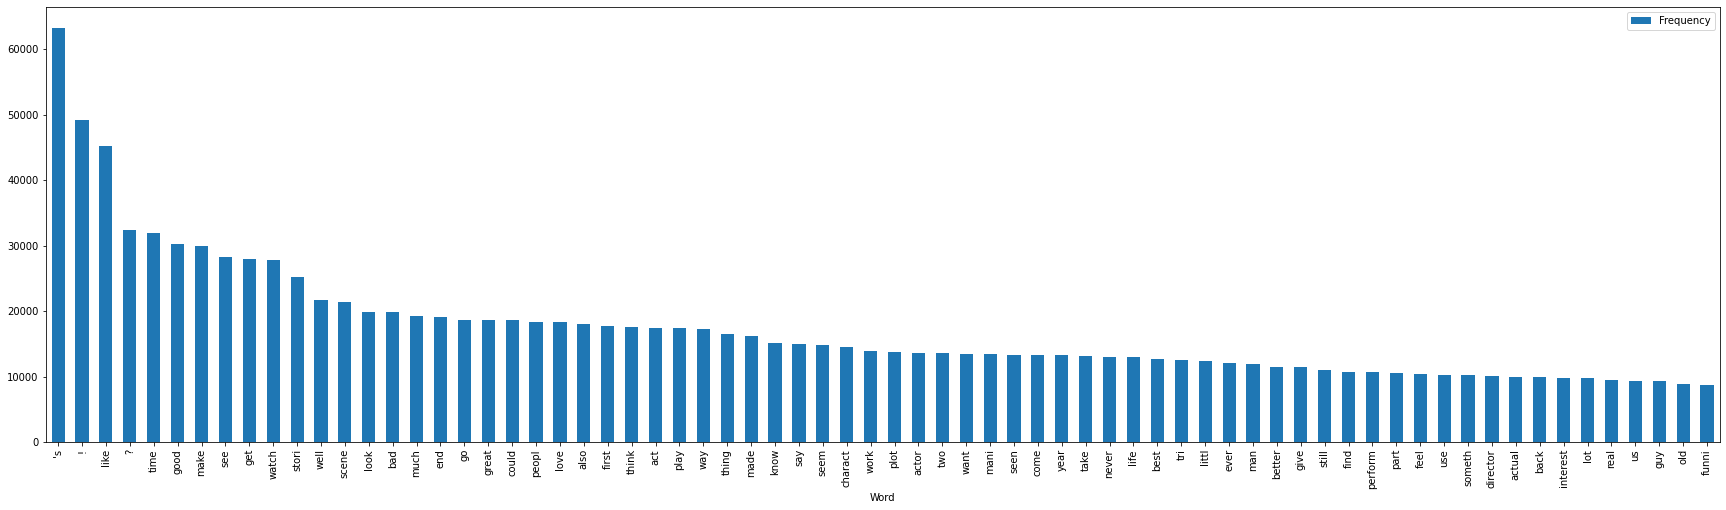

In [25]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [26]:
rslt.transpose()

Word,'s,!,like,?,time,good,make,see,get,watch,stori,well,scene,look,bad,much,end,go,great,could,peopl,love,also,first,think,act,play,way,thing,made,know,say,seem,charact,work,plot,actor,two,want,mani,seen,come,year,take,never,life,best,tri,littl,ever,man,better,give,still,find,perform,part,feel,use,someth,director,actual,back,interest,lot,real,us,guy,old,funni
Frequency,63260,49164,45189,32336,31944,30175,30012,28229,27958,27868,25268,21769,21428,19935,19805,19313,19086,18716,18699,18586,18372,18300,17972,17739,17543,17479,17364,17227,16505,16149,15176,14986,14857,14447,13885,13793,13592,13541,13498,13482,13370,13255,13254,13149,12979,12926,12625,12521,12424,12027,11960,11453,11436,10932,10775,10726,10534,10350,10226,10212,10034,10007,9946,9758,9719,9430,9383,9252,8804,8763


In [27]:
def remove_apostrophe_s(review_text):
    review_text = re.sub(r"\'s", "", review_text)
    # review_text = re.sub(r"\s{2,}", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_apostrophe_s)
sample_reviews()

bo jane parker whose long lost anthropologist father richard harri worst role inconsist career africa studi someth anoth track ? tell nativ stori giant monster whose night howl heard throughout jungl turn ape man mile o'keeff  best dialogu rescu bad guy fall love leav enough time agon two hour romp nake horni monkey look cheer normal open mind vari opinion sole except worst ever made agre seen note newsday call unendur best word summari think maltin guid comment almost think rate lower bomb

night hunter sold b style action get life grow peopl dragon wilson kick boxer hall fame actor look oscar brother look kick ass action lower low budget plot line may littl thin b understand everybodi critic man  junk anoth man  treasur get real peopl judg everi like oscar contend silli awesom fight scene mix new twist vampir move see fan rent someth els hater

ran 1959 1973 longev say lot seri also surviv chang fashion tast 50  psychedel 60  remain popular 70  rememb repeat seri success combin eleme

In [28]:
movies.sample(7)

,review,sentiment
48615,romant adventur must seem shock subvers day we...,0
43810,fascin account hunt soviet union first known ...,1
39129,william thackeray said good laugh sunshin hous...,1
7253,complet forgotten midnight mad found surf imdb...,1
23014,test watch 3 bad row find watch 3 bad row coul...,0
23637,mayb presqu rien best ever made better mani sa...,1
41834,although hail comedi drama found crooklyn most...,0


In [29]:
movies.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [0]:
movies.to_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_data_updated.csv')

## <h2> <center>Visualize the data</center></h2>

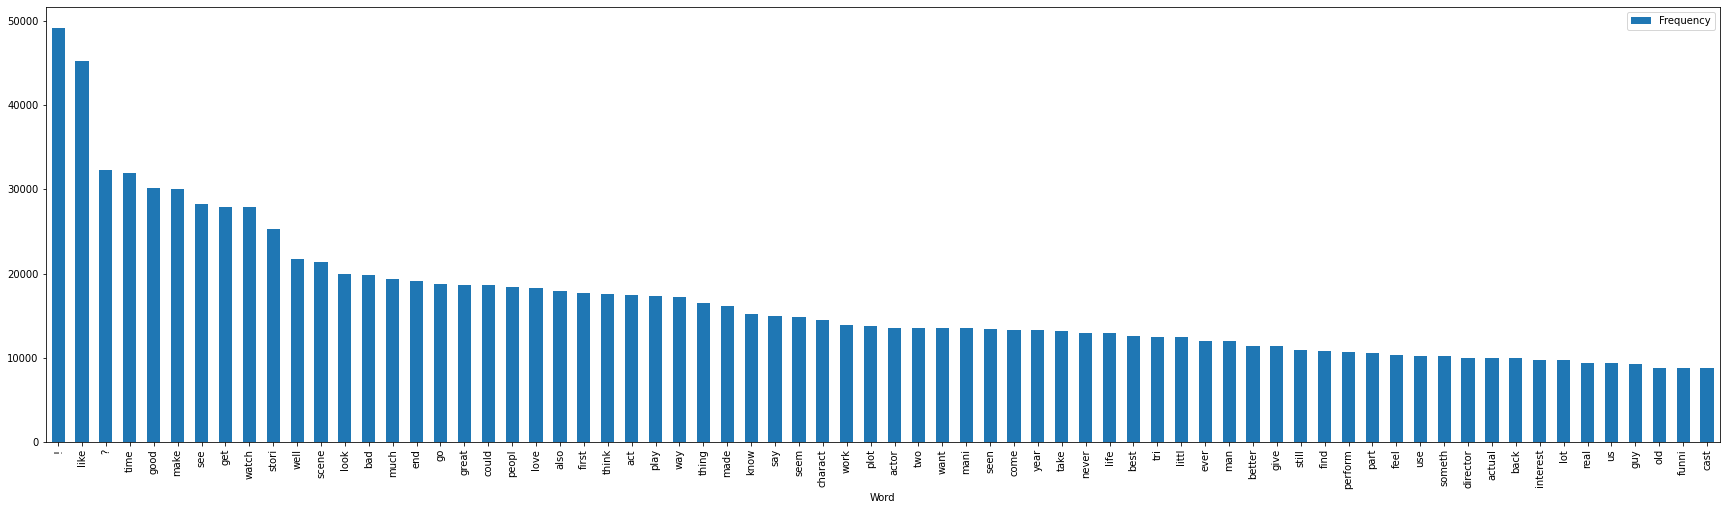

In [31]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [32]:
rslt.transpose()

Word,!,like,?,time,good,make,see,get,watch,stori,well,scene,look,bad,much,end,go,great,could,peopl,love,also,first,think,act,play,way,thing,made,know,say,seem,charact,work,plot,actor,two,want,mani,seen,come,year,take,never,life,best,tri,littl,ever,man,better,give,still,find,perform,part,feel,use,someth,director,actual,back,interest,lot,real,us,guy,old,funni,cast
Frequency,49164,45189,32336,31944,30175,30012,28229,27958,27868,25268,21769,21428,19935,19805,19313,19086,18716,18699,18586,18372,18300,17972,17739,17543,17479,17364,17227,16505,16149,15176,14986,14857,14447,13885,13793,13592,13541,13498,13482,13370,13255,13254,13149,12979,12926,12625,12521,12424,12027,11960,11453,11436,10932,10775,10726,10534,10350,10226,10212,10034,10007,9946,9758,9719,9430,9383,9252,8804,8763,8755


<h2><center> Visualize the positive and negative reviews as wordclouds </center></h2>


In [0]:
pos_string = ""
pos = movies.loc[movies.sentiment == 1, 'review']
for review in pos:
    pos_string += review
    pos_string += " "

neg_string = ""
neg = movies.loc[movies.sentiment == 0, 'review']
for review in neg:
    neg_string += review
    neg_string += " "

<center> <h2>Positve Reviews WordCloud</h2></center>


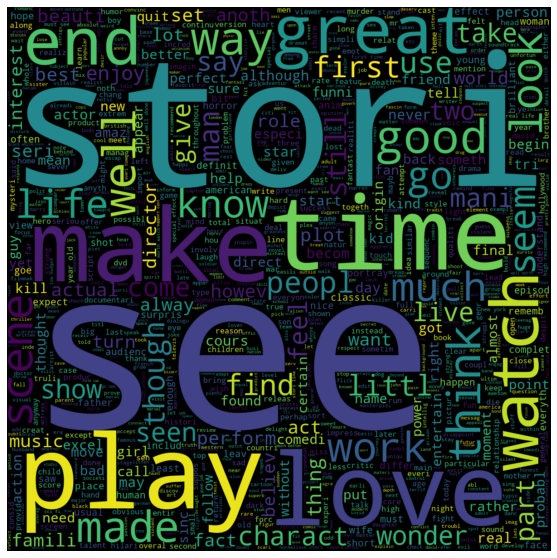

In [34]:
plt.figure(figsize=(10,10))
WC=WordCloud(width=1200, height=1200, max_words=1000, min_font_size=4)
positive_words=WC.generate(pos_string)
plt.imshow(positive_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<center> <h2>Negative reviews WordCloud</h2></center>


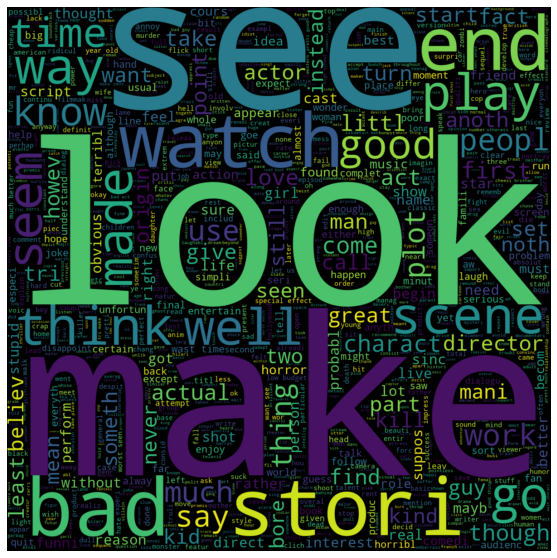

In [35]:
plt.figure(figsize=(10,10))
WC=WordCloud(width=1200, height=1200, max_words=1000, min_font_size=4)
negative_words=WC.generate(neg_string)
plt.imshow(negative_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<center> <h2>Negative  reviews top 50 word frequency distribution</h2></center>


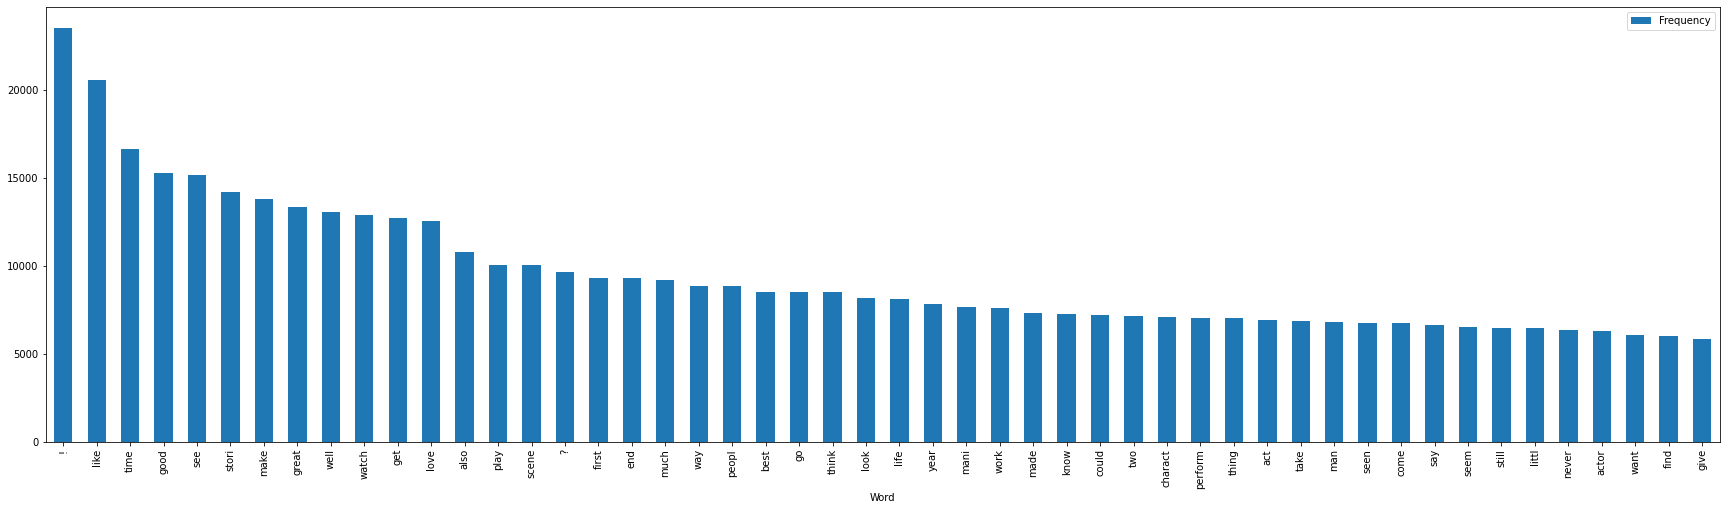

In [36]:
top_N = 50

words = (pos.str.cat(sep=' ').split())
pos_freq = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

pos_freq.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [37]:
pos_freq.transpose()

Word,!,like,time,good,see,stori,make,great,well,watch,get,love,also,play,scene,?,first,end,much,way,peopl,best,go,think,look,life,year,mani,work,made,know,could,two,charact,perform,thing,act,take,man,seen,come,say,seem,still,littl,never,actor,want,find,give
Frequency,23499,20550,16620,15258,15131,14185,13808,13332,13064,12904,12690,12523,10792,10065,10054,9669,9286,9282,9197,8857,8828,8520,8497,8486,8165,8141,7821,7661,7625,7348,7258,7200,7159,7100,7062,7037,6904,6847,6821,6757,6728,6656,6505,6460,6454,6334,6314,6093,5995,5840


In [38]:
top_N = 50

words = (neg.str.cat(sep=' ').split())
neg_freq = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
neg_freq.transpose()

Word,!,like,?,make,bad,time,get,watch,good,see,look,could,scene,stori,act,go,much,end,peopl,thing,think,made,well,plot,first,way,seem,say,know,tri,want,charact,play,actor,also,better,never,seen,ever,come,two,take,work,littl,actual,someth,noth,mani,love,guy
Frequency,25665,24639,22667,16204,15844,15324,15268,14964,14917,13098,11770,11386,11374,11083,10575,10219,10116,9804,9544,9468,9057,8801,8705,8659,8453,8370,8352,8330,7918,7609,7405,7347,7299,7278,7180,6742,6645,6613,6572,6527,6382,6302,6260,5970,5938,5896,5893,5821,5777,5775


> todo? : Updated Character, scene, like, !, make  and show to stop_words list as they are present equally in both negative and positive reviews 
| **evaluate**


<center> <h2>Positve  reviews top 50 word frequency distribution</h2></center>


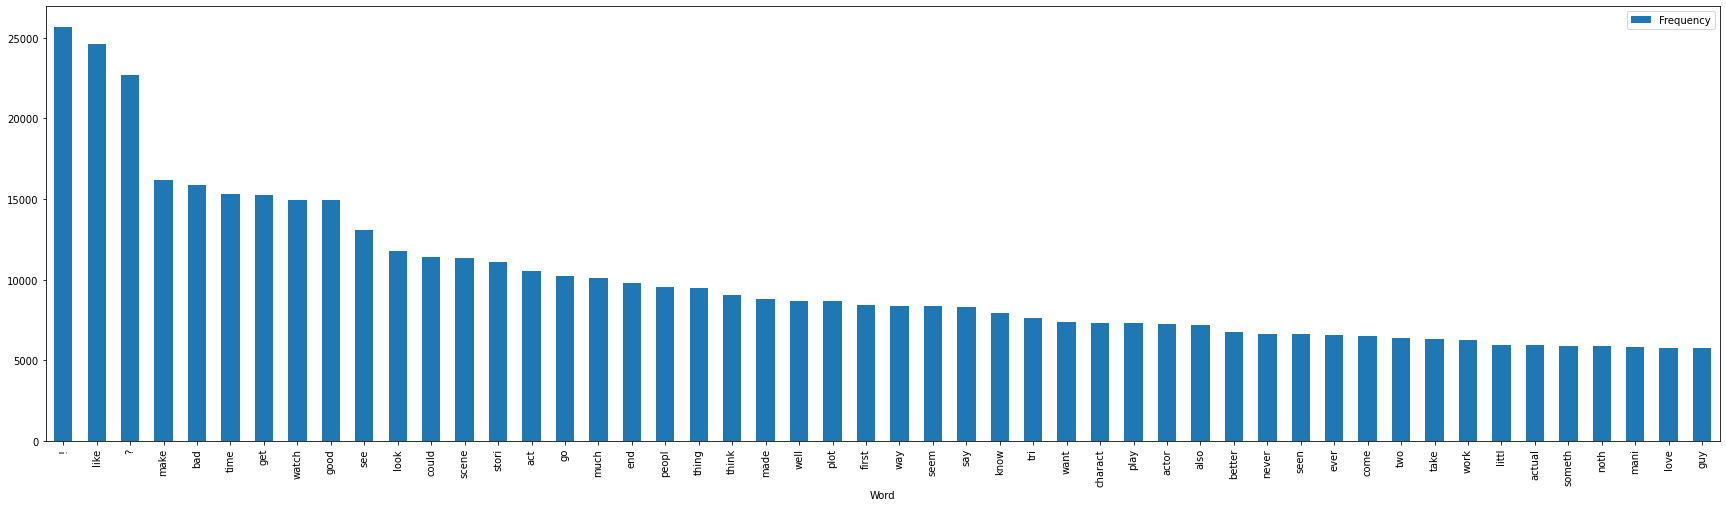

In [39]:
neg_freq.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

<center> <h2>Log Frequency distribution of length of all movie Reviews</h2></center>


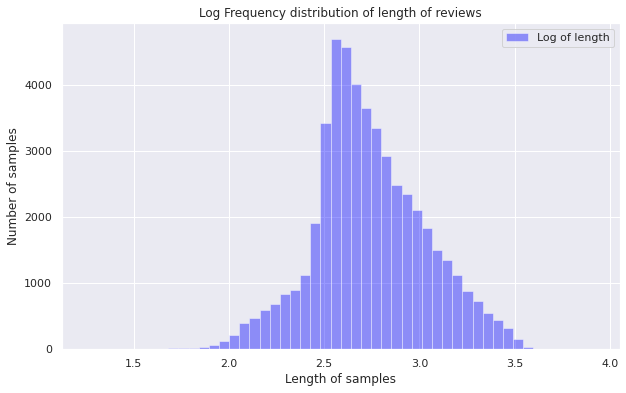

In [40]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(movies['review'])], 50, kde = False, 
             color = "blue", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of reviews')
plt.legend()
plt.show()

<center> <h2>Log Frequency distribution of length of Positive Reviews</h2></center>


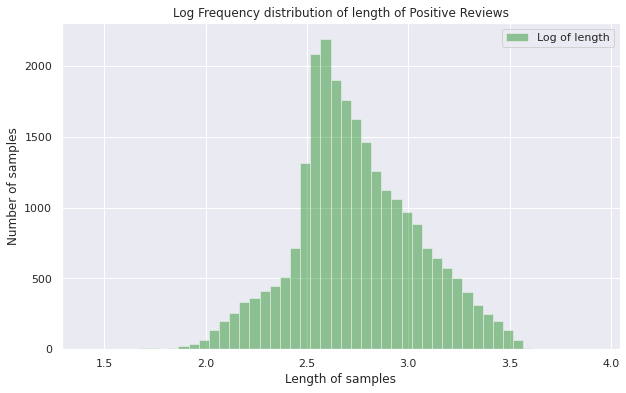

In [41]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(pos)], 50, kde = False, 
             color = "green", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of Positive Reviews')
plt.legend()
plt.show()

<center> <h2>Log Frequency distribution of length of Negative Reviews</h2></center>


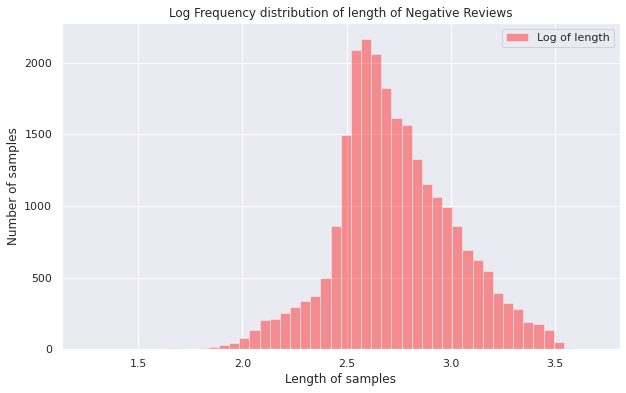

In [42]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(neg)], 50, kde = False, 
             color = "red", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of Negative Reviews')
plt.legend()
plt.show()

> **There is no significant difference in the length of positve and negative reviews**